# Import libraries and initial files

In [1]:

# Import Libraries
import pandas as pd
import numpy as np
import os
from dask import dataframe as dd
from collections import Counter

from sklearn.metrics import auc

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from dateutil.relativedelta import relativedelta

import icd10

def ConvertDate(string):
    date = pd.to_datetime(string, format='%Y-%m-%d')
    return date

def displayDataFrame(df):
    with pd.option_context('display.max_columns', None) and pd.option_context('display.max_colwidth', None):
        display(df)
    
def SummaryDataFrame(df, ConditionName):
    print('-----------------------------')
    print('\033[1m' + ConditionName.upper() + '\033[0m')
    print('\033[1m Columns: \033[0m')
    print(df.columns)
    print('\033[1m Size of dataset: \033[0m', df.shape)
    displayDataFrame(df.head(5))
    
def BoldFont(string):
    return '\033[1m ' + string + ' \033[0m'

# Playing audio prompt
import IPython
from IPython.display import Audio
sound_file = 'https://www.mediacollege.com/downloads/sound-effects/beep/beep-07.wav'

DateToday = datetime.date.today().strftime("%y.%m.%d")

def SaveFigure(plt, FigureName):
    WorkingDir = !pwd
    Path_Figures = '/'.join( WorkingDir[0].split('/')[:-1] ) + '/Figures/'
    DateToday = datetime.date.today().strftime("%y.%m.%d")
    FileName = FigureName + '_' + DateToday + '.png'
    PathName = os.path.join(Path_Figures, FileName)
    plt.savefig(PathName,
                bbox_inches='tight', dpi=300)
    print(BoldFont('FIGURE SAVED.'))


In [2]:

ReadCSV = True

# Import original dataset
CurrentPath = !pwd
PathData = '/'.join(CurrentPath[0].split('/')[0:-1]) + '/0.Data/Raw'
FileName = "Endo sinus data 06-12-21 updated.xlsx"
FilePath = os.path.join(PathData, FileName)

PathData_Figures = '/'.join(CurrentPath[0].split('/')[0:-1]) + '/Figures/'

ReadCSV = True
if ReadCSV:
    print('Importing initial dataset...')
    df_ini = pd.read_excel(FilePath)
    print(BoldFont('DONE'))
    Audio(sound_file, autoplay=True)
    
SummaryDataFrame(df_ini, 'Endoscopic Sinus Surgery')


Importing initial dataset...
 DONE 
-----------------------------
ENDOSCOPIC SINUS SURGERY
 Columns: 
Index(['P_Spell_ID', 'Epikey', 'period', 'procedure_group', 'Y761', 'sex',
       'admission_method_code', 'discharge_destination_code', 'EPIstart',
       'EPIend', 'OPERTN01', 'Consult', 'HESID', 'epiorder', 'ProvCode',
       'Region', 'Provider_Name', 'Sitecode', 'LSOA_2011_Code', 'IMD_score',
       'IMDdecile', 'main_specialty_code', 'treatment_specialty_code', 'spec',
       'age_of_patient', 'diagnosis_group', 'Index_complication', 'Diag01',
       'POD', 'SpellCCdays', 'DominantProcedure_Current',
       'SpellDominantProcedure_Current', 'MORT', 'FinY', 'Read30', 'Read90',
       'Read30_0LOS', 'Read90_0LOS', 'Read30_1a0dOverLOS',
       'Read90_1a0dOverLOS', 'Read30spellid', 'Read90spellid', 'Spell_Los',
       'Pre_op_duration', 'Post_op_duration', 'Surgery_date', 'Admission_date',
       'Discharge_date', 'ONSMort_RECORD_ID', 'ONSMort_DOD',
       'ONSMort_CAUSE_OF_DEATH', 

,P_Spell_ID,Epikey,period,procedure_group,Y761,sex,admission_method_code,discharge_destination_code,EPIstart,EPIend,...,Liver_dis,Diabetes_without,Diabetes_with,Hemi_para,Renal_dis,cancer,metastatic,Severe_liver,HIV,CCI_TOTAL
0,104782999,507052773967,FY2017-18,E081~Y761~E142~Y761~Z941~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1,1,Female,11,5993,2017-12-05,2017-12-05,...,0,0,0,0,0,0,0,0,0,0
1,47564064,508704712656,FY2018-19,E081~Y762~E133~Y761~Y713~E142~Y761~Y713~Z941~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1,1,Female,11,23949,2018-08-30,2018-08-30,...,0,0,0,0,0,0,0,0,0,1
2,128910482,505504831106,FY2016-17,E081~E081~E081~E081~Y761~Z941~E133~Y761~Z941~E142~Y761~Z943~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1,1,Female,11,36618,2016-09-05,2016-09-05,...,0,0,0,0,0,0,0,0,0,0
3,81195799,505513620008,FY2016-17,E132~Y761~Z942~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1,1,Female,11,16457,2016-09-20,2016-09-20,...,0,0,0,0,0,0,0,0,0,1
4,81461909,502713751619,FY2014-15,E132~Y761~Z942~E133~Y761~E047~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1,1,Male,11,5555,2014-04-03,2014-04-03,...,0,0,0,0,0,0,0,0,0,0


# Pre-processing and Reorganising

In [3]:

# Pre-process dataset: rename and reorganise features, convert date features
# --------------------------------------------------
def PreProcessing(df_ini):
    df = df_ini.copy()
        
    df = df.rename(columns={'IMD_score':'IMD_score',
                            'IMDdecile': 'IMD_decile'})
    
    DateFeatures = ['EPIstart', 'EPIend', 'Admission_date', 'Discharge_date',
                    'read_admission_date', 'read_discharge_date',
                    'ONSMort_DOD']
    for date in DateFeatures:
        df.loc[:, date] = ConvertDate(df.loc[:, date])
        
    df = df.rename(columns={'read_admission_date':'READ_Admission_date',
                            'read_discharge_date':'READ_Discharge_date'})
    
    # Whether a complication code was used in either index or readmission spell
    Filter_ComplicationsIndex = df['Index_complication'] == 1
    Filter_ComplicationsRead = df['READ_complication'] == 1
    Filter_Complications_Either = (Filter_ComplicationsIndex | Filter_ComplicationsRead)
    df.loc[:, 'Index_or_read_complication_ReadOrNot'] = np.where(Filter_Complications_Either, 1, 0)
    
    # Feature for readmission within 30 days with complications codes in either index or readmission spell
    Filter_Read30 = df.loc[:, 'Read30'] == 1
    df.loc[:, 'Read30_Complication_IndexOrRead'] = np.where(Filter_Read30 & Filter_Complications_Either, 1, 0)
    
    # Initial selection of features
    ColumnList_IndexSpellPatient = ['P_Spell_ID', 'HESID',
                                 'sex', 'age_of_patient', 'FinY',
                                 'Admission_date', 'Discharge_date',
                                 'EPIstart', 'EPIend',
                                 'Spell_Los',
                                 'diagnosis_group', 'Diag01', 'ProvCode',
                                 'main_specialty_code', 'treatment_specialty_code',
                                 'LSOA_2011_Code', 'IMD_score', 'IMD_decile',
                                 'HFRS_Score', 'HFRS_Band',
                                 'admission_method_code', 'discharge_destination_code', 'POD']
    
    ColumnList_IndexProcedure = ['procedure_group', 'OPERTN01', 'DominantProcedure_Current',
                                 'ENT_Condition', 'ENT_CancerMSR', 'ENT_ProcGroup1']

    ColumnList_Complications = ['Index_complication', 'READ_complication',
                                'Index_or_read_complication', 'Index_or_read_complication_ReadOrNot',
                                'Read30_Complication_IndexOrRead']
    
    ColumnList_Comorbidities = ['Periferal_vasc',
                             'heart_fail', 'Acute_MI', 'cerebral_vasc', 'dementia', 'Pulmonary_dis',
                             'Connective', 'Peptic_ulcer', 'Liver_dis', 'Diabetes_without',
                             'Diabetes_with', 'Hemi_para', 'Renal_dis', 'cancer', 'metastatic',
                             'Severe_liver', 'HIV', 'CCI_TOTAL']

    ColumnList_Outcomes = ['MORT', 'Read30',
                           'ReturnENT1yr', 'ProcENT1yr']
    
    ColumnList_Read = ['READ_Admission_date', 'READ_Discharge_date',
                       'READ_procedure', 'READ_diagnosis']
    
    ColumnList_All = ColumnList_IndexSpellPatient+ColumnList_IndexProcedure+ColumnList_Complications \
                    +ColumnList_Comorbidities+ColumnList_Read+ ColumnList_Outcomes

    df = df.loc[:, ColumnList_All].sort_values(by=['P_Spell_ID', 'Admission_date', 'EPIstart', 'EPIend'])
    
    Nb_UniquePatients = df.drop_duplicates(subset=['HESID']).shape[0]
    if Nb_UniquePatients==df.shape[0]:
        print('Datasets contains UNIQUE spells for each patient.')
    else:
        print('Datasets contains duplicates entries for same patients.')   
    
    return df
# --------------------------------------------------

df = PreProcessing(df_ini)
SummaryDataFrame(df, 'Endosinus Readmissions')


Datasets contains UNIQUE spells for each patient.
-----------------------------
ENDOSINUS READMISSIONS
 Columns: 
Index(['P_Spell_ID', 'HESID', 'sex', 'age_of_patient', 'FinY',
       'Admission_date', 'Discharge_date', 'EPIstart', 'EPIend', 'Spell_Los',
       'diagnosis_group', 'Diag01', 'ProvCode', 'main_specialty_code',
       'treatment_specialty_code', 'LSOA_2011_Code', 'IMD_score', 'IMD_decile',
       'HFRS_Score', 'HFRS_Band', 'admission_method_code',
       'discharge_destination_code', 'POD', 'procedure_group', 'OPERTN01',
       'DominantProcedure_Current', 'ENT_Condition', 'ENT_CancerMSR',
       'ENT_ProcGroup1', 'Index_complication', 'READ_complication',
       'Index_or_read_complication', 'Index_or_read_complication_ReadOrNot',
       'Read30_Complication_IndexOrRead', 'Periferal_vasc', 'heart_fail',
       'Acute_MI', 'cerebral_vasc', 'dementia', 'Pulmonary_dis', 'Connective',
       'Peptic_ulcer', 'Liver_dis', 'Diabetes_without', 'Diabetes_with',
       'Hemi_para',

,P_Spell_ID,HESID,sex,age_of_patient,FinY,Admission_date,Discharge_date,EPIstart,EPIend,Spell_Los,...,HIV,CCI_TOTAL,READ_Admission_date,READ_Discharge_date,READ_procedure,READ_diagnosis,MORT,Read30,ReturnENT1yr,ProcENT1yr
46471,2993,0000FFD16F52D58CFAD1925D755E495E,Male,45,2017/18,2018-02-20,2018-02-21,2018-02-20,2018-02-21,1,...,0,0,NaT,NaT,NaN,NaN,0,0,0,1
38451,9752,00031BCD98A46C7F4C9D164D827E4609,Female,54,2014/15,2014-12-08,2014-12-09,2014-12-08,2014-12-09,1,...,0,1,NaT,NaT,NaN,NaN,0,0,0,1
5928,9760,00031BCD98A46C7FB7BBACB4877EED0E,Female,54,2014/15,2015-02-19,2015-02-19,2015-02-19,2015-02-19,0,...,0,0,NaT,NaT,NaN,NaN,0,0,0,1
30359,12034,0003EBEB13E44D5204D9A086EF2BB1E3,Male,67,2018/19,2018-06-13,2018-06-13,2018-06-13,2018-06-13,0,...,0,0,NaT,NaT,NaN,NaN,0,0,0,1
30666,21284,00067749D7D3AF745C317DD0DAC0E131,Female,29,2018/19,2018-06-27,2018-06-27,2018-06-27,2018-06-27,0,...,0,0,NaT,NaT,NaN,NaN,0,0,1,1


In [4]:

# Engineering features of interest
# --------------------------------------------------
def FeatureEngineering(df_ini):
    df = df_ini.copy()
    
    # Obesity diagnosisin index spell
    Filter_IndexObesity = df.loc[:, 'diagnosis_group'].str.contains('E66')
    df.loc[:, 'Index_Obesity'] = np.where(Filter_IndexObesity, 1, 0)
    
    # Time between readmission and index spells
    df.loc[:, 'READ_TimeDifference'] = (df.loc[:, 'READ_Admission_date'] - df.loc[:, 'Discharge_date']).dt.days
    
    # Number of patients in each trust, in each FinY
    ColumnList = ['P_Spell_ID', 'ProvCode', 'FinY']
    df.loc[:, 'Trust_NumberPatients'] = df.loc[:, ColumnList].groupby(by=['ProvCode', 'FinY']).transform('count').values    
    
    # Read30 OR complication code in index spell
    Filter_ReadOrIndexComplication = df.loc[:, 'Read30'] + df.loc[:, 'Index_complication'] >= 1
    df.loc[:, 'Read30_Or_Index_Complication'] = np.where(Filter_ReadOrIndexComplication, 1, 0)
    
    # Potential secondary outcome
    Ndays = 20
    Read_NameFeature = 'Read_'+str(Ndays)
    Filter_Read = df.loc[:, 'READ_TimeDifference'] <= Ndays
    df.loc[:, Read_NameFeature] = np.where(Filter_Read, 1, 0)
    
# -------
# TESTING: OPCS codes with statistically signifiant difference in proportions relative to Read30
    def Code_Presence(df_ini, Code_List, Name):
        if 'OPCS' in Name:
            if 'Index' in Name:
                FeatureName = 'procedure_group'
            else:
                FeatureName = 'READ_procedure'
        else:
            if 'Index' in Name:
                FeatureName = 'diagnosis_group'
            else:
                FeatureName = 'READ_diagnosis'

        for code in Code_List:
            Filter_Code = df_ini.loc[:, FeatureName].str.contains(code)
            df_ini.loc[:, Name+'_'+code] = np.where(Filter_Code, 1, 0)
        return df_ini

    OPCS_List_Index = ['Z941', 'E133', 'E081', 'Y762', 'E036', 'Z943', 'E042', 'Y713']
    OPCS_List_Read = ['Z941', 'E063', 'Z942', 'Z943', 'U212', 'E064', 'U051']
    df = Code_Presence(df, OPCS_List_Index, 'OPCS_Index')
#     df = Code_Presence(df, OPCS_List_Read, 'OPCS_Read30')
    
    ICD10_List_Index = ['J329', 'J339', 'I10X', 'J342', 'Z864', 'J343', 'F171', 'J320', 'E119', 'K219', 'Z880']
    ICD10_List_Read = ['R040', 'I10X', 'J459', 'Y838', 'T810', 'Z870', 'Z864', 'J329', 'R51X', 'E119', 'F171', 'F329']
    df = Code_Presence(df, ICD10_List_Index, 'ICD10_Index')
#     df = Code_Presence(df, ICD10_List_Read, 'ICD10_Read30')
    
# -------

    ColumnList_Code = [col for col in df.columns if ('OPCS' in col or 'ICD10' in col)] 
    
    ColumnList_IndexSpellPatient = ['sex', 'age_of_patient', 'FinY',
                                 'Spell_Los',
                                 'ProvCode', 'Trust_NumberPatients', 
                                 'main_specialty_code', 'treatment_specialty_code',
                                 'IMD_score',
                                 'HFRS_Score',
                                 'POD']
    
    ColumnList_IndexProcedure = ['OPERTN01', 'DominantProcedure_Current',
                                 'ENT_Condition', 'ENT_CancerMSR', 'ENT_ProcGroup1']

    ColumnList_Complications = ['Index_complication', 'READ_complication',
                                'Index_or_read_complication', 'Index_or_read_complication_ReadOrNot',
                                'Read30_Complication_IndexOrRead',
                                'Read30_Or_Index_Complication',
                                 Read_NameFeature]
    
    ColumnList_Comorbidities = ['Periferal_vasc',
                             'heart_fail', 'Acute_MI', 'cerebral_vasc', 'dementia', 'Pulmonary_dis',
                             'Connective', 'Peptic_ulcer', 'Liver_dis', 'Diabetes_without',
                             'Diabetes_with', 'Hemi_para', 'Renal_dis', 'cancer', 'metastatic',
                             'Severe_liver', 'HIV', 'CCI_TOTAL']
    
    ColumnList_Additional = ['Index_Obesity', 'READ_TimeDifference']

    ColumnList_Outcomes = ['MORT', 'Read30',
                           'ReturnENT1yr', 'ProcENT1yr']
    
    ColumnList_All = ColumnList_Code \
                    + ColumnList_IndexSpellPatient+ColumnList_IndexProcedure+ColumnList_Complications \
                    + ColumnList_Comorbidities+ColumnList_Additional+ColumnList_Outcomes

    df = df.loc[:, ColumnList_All]
        
    return df

df_FeatureEngineered = FeatureEngineering(df)
SummaryDataFrame(df_FeatureEngineered, 'Endosinus Readmissions')



-----------------------------
ENDOSINUS READMISSIONS
 Columns: 
Index(['OPCS_Index_Z941', 'OPCS_Index_E133', 'OPCS_Index_E081',
       'OPCS_Index_Y762', 'OPCS_Index_E036', 'OPCS_Index_Z943',
       'OPCS_Index_E042', 'OPCS_Index_Y713', 'ICD10_Index_J329',
       'ICD10_Index_J339', 'ICD10_Index_I10X', 'ICD10_Index_J342',
       'ICD10_Index_Z864', 'ICD10_Index_J343', 'ICD10_Index_F171',
       'ICD10_Index_J320', 'ICD10_Index_E119', 'ICD10_Index_K219',
       'ICD10_Index_Z880', 'sex', 'age_of_patient', 'FinY', 'Spell_Los',
       'ProvCode', 'Trust_NumberPatients', 'main_specialty_code',
       'treatment_specialty_code', 'IMD_score', 'HFRS_Score', 'POD',
       'OPERTN01', 'DominantProcedure_Current', 'ENT_Condition',
       'ENT_CancerMSR', 'ENT_ProcGroup1', 'Index_complication',
       'READ_complication', 'Index_or_read_complication',
       'Index_or_read_complication_ReadOrNot',
       'Read30_Complication_IndexOrRead', 'Read30_Or_Index_Complication',
       'Read_20', 'Perifer

,OPCS_Index_Z941,OPCS_Index_E133,OPCS_Index_E081,OPCS_Index_Y762,OPCS_Index_E036,OPCS_Index_Z943,OPCS_Index_E042,OPCS_Index_Y713,ICD10_Index_J329,ICD10_Index_J339,...,metastatic,Severe_liver,HIV,CCI_TOTAL,Index_Obesity,READ_TimeDifference,MORT,Read30,ReturnENT1yr,ProcENT1yr
46471,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,NaN,0,0,0,1
38451,1,1,1,1,0,0,0,0,1,0,...,0,0,0,1,0,NaN,0,0,0,1
5928,1,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,NaN,0,0,0,1
30359,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,NaN,0,0,0,1
30666,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,NaN,0,0,1,1


# Exploratory analysis: readmission threshold

Total number of admissions: 49465
Number of admissions dropped, without readmissions: 47690 
 Number of readmissions remaining: 1775


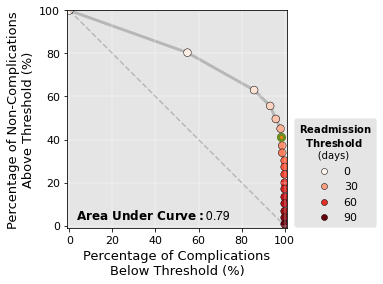

In [5]:

# study readmission treshold
df_read = df.copy()
NRead_ini = df_read.shape[0]
print('Total number of admissions:', NRead_ini)
df_read = df_read.dropna(subset=['READ_Admission_date'])
print('Number of admissions dropped, without readmissions:', NRead_ini-df_read.shape[0],
      '\n Number of readmissions remaining:', df_read.shape[0])

df_read.loc[:, 'RandomBinary'] = np.random.randint(0,2, size=(df_read.shape[0], 1))

ReadFeature = 'Index_or_read_complication_ReadOrNot'
ReadFeature = 'READ_complication'
# ReadFeature = 'RandomBinary'
DateFeature = 'Discharge_date'

List_PropComplications_WithinThreshold = []
List_PropNotComplications_OutThreshold = []
List_ReadThreshold_Days = range(0, 95, 5)

# Separate readmissions according to day threshold
for ReadThreshold_Days in List_ReadThreshold_Days:
    df_read.loc[:, 'READ_TimeDifference'] = (df_read.loc[:, 'READ_Admission_date'] - df_read.loc[:, DateFeature]).dt.days
    Filter_ReadWithinThreshold = (df_read.loc[:, 'READ_TimeDifference'] < ReadThreshold_Days)
    df_ReadWithinThreshold = df_read.loc[Filter_ReadWithinThreshold, :]
    df_ReadOutThreshold = df_read.loc[~Filter_ReadWithinThreshold, :].dropna(subset=['READ_TimeDifference'])

    PrintDescription = False
    if PrintDescription:
        print(BoldFont('Readmission threshold:'), ReadThreshold_Days, 'days.')
        print('Number of spells within readmission threshold:', df_ReadWithinThreshold.shape[0])
        print('Number of spells above readmission threshold, among <=90-day readmissions:', df_ReadOutThreshold.shape[0])

    # Proportion of spells with complication codes
    NumberComplications_Total = df_read.loc[:, ReadFeature].sum()
    NotComplications_Total = df_read.shape[0] - NumberComplications_Total

    NumberComplications_WithinThreshold = df_ReadWithinThreshold.loc[:, ReadFeature].sum()
    NotComplications_OutThreshold = df_ReadOutThreshold.shape[0] - df_ReadOutThreshold.loc[:, ReadFeature].sum()

    PropComplications_WithinThreshold = 100 * NumberComplications_WithinThreshold / NumberComplications_Total
    PropNotComplications_OutThreshold = 100 * NotComplications_OutThreshold / NotComplications_Total

    List_PropComplications_WithinThreshold.append(PropComplications_WithinThreshold)
    List_PropNotComplications_OutThreshold.append(PropNotComplications_OutThreshold)

fig, ax = plt.subplots(figsize=(4, 4))
# Plot dataframe
df_plot = pd.DataFrame({'PropComplications_WithinThreshold':List_PropComplications_WithinThreshold,
                        'PropNotComplications_OutThreshold':List_PropNotComplications_OutThreshold,
                        'ReadThreshold_Days':List_ReadThreshold_Days})
sns.scatterplot(data = df_plot,
            x = 'PropComplications_WithinThreshold',
            y = 'PropNotComplications_OutThreshold',
            hue = 'ReadThreshold_Days',
            palette='Reds',
            s = 60,
            zorder=1,
            edgecolor="black",
            linewidth=0.5)

# Plot curve
X = df_plot.loc[:, 'PropComplications_WithinThreshold']
Y = df_plot.loc[:, 'PropNotComplications_OutThreshold']
Opacity = 0.2
plt.plot(X, Y,
        zorder=0,
        linestyle='-',
        linewidth=3,
        color=[0, 0, 0, Opacity])
Area = auc(X, Y)/100**2

# Plot main diagonal
Opacity = 0.2
X = range(0, 110, 10)
Y = [100 - i for i in X]
plt.plot(X, Y,
        linestyle = '--',
        color = [0, 0, 0, Opacity])

# Highlight 30 day readmission point
Filter_30days = df_plot.loc[:, 'ReadThreshold_Days']==30
X_30 = df_plot.loc[Filter_30days, 'PropComplications_WithinThreshold']
Y_30 = df_plot.loc[Filter_30days, 'PropNotComplications_OutThreshold']
plt.scatter(X_30, Y_30,
           edgecolor=[107/255,142/255,35/255],
           facecolor=None,
           zorder=4,
           linewidth=3)

# Legend and axes
handles, labels = ax.get_legend_handles_labels()
for ha in handles:
    ha.set_edgecolor("black")
    ha.set_linewidth(0.5)

labels = [str(i) for i in range(0, 90+20, 15)]
    
lgd = ax.legend(
    handles[::2], 
    labels[::2],
    title=r'$\bf{Readmission}$'+ '\n' + r'  $\bf{Threshold}$' + '\n' + r'      (days)',
    fontsize=11,
    loc='lower left',
    bbox_to_anchor=(1.01, -0.02),
    facecolor=[0, 0, 0],
    framealpha=0.1)

# Plot area under curve
String = r"$\bf{Area \ Under \ Curve: }$" + str(Area)[0:4]
plt.text(x=3, y=3, s=String,
         font='helvetica',
         fontsize=12)

ax.set_facecolor((0, 0, 0, 0.1))
plt.axis('square')
plt.xlim(-1, 101)
plt.ylim(-1, 100)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.xlabel('Percentage of Complications' + '\n' + 'Below Threshold (%)',
           fontsize=13)
plt.ylabel('Percentage of Non-Complications' + '\n' + 'Above Threshold (%)',
          fontsize=13)

plt.grid(b='on', alpha=0.2,
         linewidth=2,
         color=[1, 1, 1])

PathData_Figures = '/'.join(CurrentPath[0].split('/')[0:-1]) + '/Figures/'

SaveFig = False
if SaveFig:
    plt.savefig(PathData_Figures+'AUROC_Readmission.png',
                bbox_inches='tight', dpi=300)
    print(BoldFont('Figure saved.'.upper()))



# Exploratory analysis: profile of ESS patients (table 1)

In [6]:

# Number of patients
print(BoldFont('Total number of patients:'), df_FeatureEngineered.shape[0])

# Median age 
DescribeAge = df_FeatureEngineered.loc[:, 'age_of_patient'].describe()
Median = DescribeAge['50%']
IQR = [DescribeAge['25%'], DescribeAge['75%']]
print(BoldFont('Age:'), Median, '(', IQR[0], '-', IQR[1], ')', 'years' )

# Number of female patients 
Filter_Female = df_FeatureEngineered.loc[:, 'sex']=='Female'
Number_Female = df_FeatureEngineered.loc[Filter_Female, 'sex'].shape[0]
Prop_Female = 100 * Number_Female / df_FeatureEngineered.shape[0]
print(BoldFont('Female patients:'), Number_Female,
     'corresponding to %0.2f' % Prop_Female, '%')

# Financial Years
List_FinY = [i for i in set(list(df_FeatureEngineered['FinY'].values))]
print(BoldFont('Financial years:'))
for FinY in List_FinY:
    Filter_FinY = df_FeatureEngineered.loc[:, 'FinY']==FinY
    Number_Patients = df_FeatureEngineered.loc[Filter_FinY, :].shape[0]
    print('\t', FinY, ':', Number_Patients, 
         'corresponding to %0.2f' % (100*Number_Patients/df_FeatureEngineered.shape[0]), '%')

# Asthma
Codes_Asthma = 'J452|J453|J454|J455|J459'
Filter_Asthma = df.loc[:, 'diagnosis_group'].str.contains(Codes_Asthma)
Number_Asthma =  df.loc[Filter_Asthma, :].shape[0]
print(BoldFont('Asthma:'), Number_Asthma,
         'corresponding to %0.2f' % (100*Number_Asthma/df.shape[0]), '%')

# Smoking
Codes_Smoking = 'Z720|F17'
Filter_Smoking = df.loc[:, 'diagnosis_group'].str.contains(Codes_Smoking)
Number_Smoking =  df.loc[Filter_Smoking, :].shape[0]
print(BoldFont('Smoking:'), Number_Smoking,
         'corresponding to %0.2f' % (100*Number_Smoking/df.shape[0]), '%')

# Ischemic Heart Diseases
Codes_IHD = 'I20|I21|I22|I23|I24|I25'
Filter_IHD = df.loc[:, 'diagnosis_group'].str.contains(Codes_IHD)
Number_IHD =  df.loc[Filter_IHD, :].shape[0]
print(BoldFont('Ischemic Heart Diseases:'), Number_IHD,
         'corresponding to %0.2f' % (100*Number_IHD/df.shape[0]), '%')

# Diabetes Mellius
Filter_DM =( df.loc[:, 'Diabetes_with']+df.loc[:, 'Diabetes_without']>0)
Number_DM =  df.loc[Filter_DM, :].shape[0]
print(BoldFont('Diabetic Mellitus:'), Number_DM,
         'corresponding to %0.2f' % (100*Number_DM/df.shape[0]), '%')

# Emergency 30-day readmission
Number_Read30 = df.loc[:, 'Read30'].sum()
print(BoldFont('Emergency 30-day Read:'), Number_Read30,
      'corresponding to %0.2f' % (100*Number_Read30/df.shape[0]), '%')

# Return for Lumbar Surgery within 90 days of discharge
Number_ReturnENT90 = df_ini.loc[:, 'ReturnENT90'].sum()
print(BoldFont('90-day returns for lumbar surgery:'), Number_ReturnENT90,
      'corresponding to %0.2f' % (100*Number_ReturnENT90/df_ini.shape[0]), '%')

# Return for Lumbar Surgery within 1 year of discharge
Number_ReturnENT1yr = df_ini.loc[:, 'ReturnENT1yr'].sum()
print(BoldFont('1-year returns for lumbar surgery:'), Number_ReturnENT1yr,
      'corresponding to %0.2f' % (100*Number_ReturnENT1yr/df_ini.shape[0]), '%')

# LOS > 2 days
Filter_LOSp2d = df_ini.loc[:, 'Spell_Los']>2
N_LOSp2d = df_ini.loc[Filter_LOSp2d, :].shape[0]
print(BoldFont('LOS > 2 days:'), N_LOSp2d,
      'corresponding to %0.2f' % (100*N_LOSp2d/df_ini.shape[0]), '%')

# Death within 1 yr of discharge
Filter_Death1yr = (df_ini.loc[:, 'ONSMort_DOD'] - df_ini.loc[:, 'Discharge_date']).dt.days <= 365.25
N_Death1yr = df_ini.loc[Filter_Death1yr, :].shape[0]
print(BoldFont('Death within 1 year:'), N_Death1yr,
      'corresponding to %0.2f' % (100*N_Death1yr/df_ini.shape[0]), '%')

# Post-procedural complication during index or readmission spell, within 30 days
Filter_IndexComplication = df_ini.loc[:, 'Index_complication']==1
Filter_ReadComplication = df_ini.loc[:, 'READ_complication']==1
Filter_Read30 = df_ini.loc[:, 'Read30']==1
Filter_All = Filter_IndexComplication | (Filter_ReadComplication & Filter_Read30)
N_Complication_IndexOr30Read = df_ini.loc[Filter_All, :].shape[0]
print(BoldFont('Index or 30Read complications:'), N_Complication_IndexOr30Read,
      'corresponding to %0.2f' % (100*N_Complication_IndexOr30Read/df_ini.shape[0]), '%')

# Pain recorded in 30-day readmission
# codes: https://www.icd10data.com/ICD10CM/Codes/G00-G99/G89-G99/G89-
Codes_Pain = 'R52|G89|G50|G44|R51|G43'
Filter_Pain30Read = df_ini.loc[:, 'READ_diagnosis'].fillna('None').str.contains(Codes_Pain)
Number_Pain30Read =  df_ini.loc[Filter_Pain30Read, :].shape[0]
print(BoldFont('Pain on 30-day readmission:'), Number_Pain30Read,
         'corresponding to %0.2f' % (100*Number_Pain30Read/df_ini.shape[0]), '%')


 Total number of patients:  49465
 Age:  51.0 ( 39.0 - 62.0 ) years
 Female patients:  20263 corresponding to 40.96 %
 Financial years: 
	 2017/18 : 9701 corresponding to 19.61 %
	 2016/17 : 10416 corresponding to 21.06 %
	 2014/15 : 10141 corresponding to 20.50 %
	 2018/19 : 9129 corresponding to 18.46 %
	 2015/16 : 10078 corresponding to 20.37 %
 Asthma:  12530 corresponding to 25.33 %
 Smoking:  5297 corresponding to 10.71 %
 Ischemic Heart Diseases:  1432 corresponding to 2.89 %
 Diabetic Mellitus:  2836 corresponding to 5.73 %
 Emergency 30-day Read:  1163 corresponding to 2.35 %
 90-day returns for lumbar surgery:  688 corresponding to 1.39 %
 1-year returns for lumbar surgery:  2322 corresponding to 4.69 %
 LOS > 2 days:  349 corresponding to 0.71 %
 Death within 1 year:  149 corresponding to 0.30 %
 Index or 30Read complications:  866 corresponding to 1.75 %
 Pain on 30-day readmission:  138 corresponding to 0.28 %


# Exploration: Look for potential predictors

In [7]:

# Grouping post-procedural complications on single categorical variable
# --------------------------------------------------
def Complications_GroupedByCategoricalVariable(df_ini, CategoricalVariable, Outcome):
    print('Grouping by:', BoldFont(CategoricalVariable.upper()))
    print('In relation to outcome:', BoldFont(Outcome.upper()))
    ColumnList = [CategoricalVariable] + [Outcome]
    
    df = df_ini.copy()
    df_Grouped = df.loc[:, ColumnList]

    df_Grouped.loc[:, 'Grouped_Sum'] = df_Grouped.groupby(by=[CategoricalVariable])[Outcome].transform('sum')
    df_Grouped.loc[:, 'Grouped_Count'] = df_Grouped.groupby(by=[CategoricalVariable])[Outcome].transform('count')
    df_Grouped.loc[:, 'Grouped_Prop'] = 100 * df_Grouped.loc[:, 'Grouped_Sum'] / df_Grouped.loc[:, 'Grouped_Count']

    df_Grouped = df_Grouped.sort_values(by=['Grouped_Count'], ascending=False).drop_duplicates(subset=[CategoricalVariable])
    df_Grouped = df_Grouped.drop(columns=[Outcome])
    
    return df_Grouped
# --------------------------------------------------

Plot_Funnel = False
if Plot_Funnel:
    X = df_Grouped['Grouped_Count']
    Y = df_Grouped['Grouped_Prop']
    plt.scatter(X, Y)
    plt.ylim(0, 5)

# main_specialty_code
df_Grouped = Complications_GroupedByCategoricalVariable(df_FeatureEngineered, 'DominantProcedure_Current', 'Read30')
df_Grouped.head(5)



Grouping by:  DOMINANTPROCEDURE_CURRENT 
In relation to outcome:  READ30 


,DominantProcedure_Current,Grouped_Sum,Grouped_Count,Grouped_Prop
46584,E081,230.0,10305.0,2.231926
18297,E133,173.0,6755.0,2.561066
16620,E142,126.0,5683.0,2.217139
8895,E036,140.0,4436.0,3.155996
47105,E148,102.0,4302.0,2.370990


In [8]:

# Perform Chi-square test to explore potential relationship between a CatVariable and an outcome
# --------------------------------------------------
def Chi2Test(df_ini, CatVariable_1, CatVariable_2):
    from scipy.stats import chi2_contingency

    # create contingency table
    df = df_ini
    data_crosstab = pd.crosstab(df[CatVariable_1],
                                df[CatVariable_2],
                                margins=True, margins_name="Total")

    c, p, dof, expected = chi2_contingency(data_crosstab) 
    print(CatVariable_1, '-', CatVariable_2, ', p-value: %0.2f' % p)
    
    return c, p, dof, expected
# --------------------------------------------------

c, p, dof, expected = Chi2Test(df_FeatureEngineered, 'ENT_ProcGroup1', 'Read30')


ENT_ProcGroup1 - Read30 , p-value: 0.22


In [26]:

# Select and encode features
# --------------------------------------------------
def SelectEncodeFeatures(df_ini):
    df = df_ini.copy()
    
    ColumnList = ['sex', 'age_of_patient', 'Trust_NumberPatients', 'Spell_Los',
               'IMD_score',
               'HFRS_Score',
               'OPERTN01',
               'ENT_CancerMSR', 'ENT_ProcGroup1',
               'Periferal_vasc', 'heart_fail', 'Acute_MI', 'cerebral_vasc', 'dementia',
               'Pulmonary_dis', 'Connective', 'Peptic_ulcer', 'Liver_dis',
               'Diabetes_without', 'Diabetes_with', 'Hemi_para', 'Renal_dis', 'cancer',
               'metastatic', 'Severe_liver', 'HIV',
               'Index_Obesity',
               'CCI_TOTAL',
               'READ_TimeDifference',
               'Index_complication', 'READ_complication', 'Index_or_read_complication_ReadOrNot',
               'Read30_Or_Index_Complication',
               'MORT', 'Read30']
    
    ColumnList_Code = [col for col in df.columns if ('OPCS' in col or 'ICD10' in col)] 
    
    ColumnList_All = ColumnList + ColumnList_Code

    df = df.loc[:, ColumnList_All]

    Variables_Categorical = [col for col in df.columns if df[col].dtypes=='object']

    for var in Variables_Categorical:
        df = pd.get_dummies(df, prefix=var, 
                                    columns=[var], 
                                    drop_first=False)

    ColumnDrop_1 = ['sex_Not specified', 'sex_Female',
                  'ENT_CancerMSR_other',
                  'ENT_ProcGroup1_OtherENTProc']

    ColumnDrop_2 = ['READ_TimeDifference', 'Index_complication', 'READ_complication'] + ['Read30_Or_Index_Complication']
    
    ColumnDrop = ColumnDrop_1 + ColumnDrop_2
    Outcome = 'Read30'

    df = df.drop(columns=ColumnDrop)
    ColumnList_Ordered = [col for col in df.columns if col!=Outcome] + [Outcome]
    df = df.loc[:, ColumnList_Ordered]
    
    # Print characteristics
    print('Number of patients:', df.shape[0])
    print('Number of features:', df.shape[1])
    print('Proportion of Read30: %0.2f' % (100*df[Outcome].mean()), '%')

    return df
# --------------------------------------------------

df_Encoded = SelectEncodeFeatures(df_FeatureEngineered)
SummaryDataFrame(df_Encoded, 'Endosinus')


Number of patients: 49465
Number of features: 55
Proportion of Read30: 2.35 %
-----------------------------
ENDOSINUS
 Columns: 
Index(['age_of_patient', 'Trust_NumberPatients', 'Spell_Los', 'IMD_score',
       'HFRS_Score', 'Periferal_vasc', 'heart_fail', 'Acute_MI',
       'cerebral_vasc', 'dementia', 'Pulmonary_dis', 'Connective',
       'Peptic_ulcer', 'Liver_dis', 'Diabetes_without', 'Diabetes_with',
       'Hemi_para', 'Renal_dis', 'cancer', 'metastatic', 'Severe_liver', 'HIV',
       'Index_Obesity', 'CCI_TOTAL', 'Index_or_read_complication_ReadOrNot',
       'MORT', 'OPCS_Index_Z941', 'OPCS_Index_E133', 'OPCS_Index_E081',
       'OPCS_Index_Y762', 'OPCS_Index_E036', 'OPCS_Index_Z943',
       'OPCS_Index_E042', 'OPCS_Index_Y713', 'ICD10_Index_J329',
       'ICD10_Index_J339', 'ICD10_Index_I10X', 'ICD10_Index_J342',
       'ICD10_Index_Z864', 'ICD10_Index_J343', 'ICD10_Index_F171',
       'ICD10_Index_J320', 'ICD10_Index_E119', 'ICD10_Index_K219',
       'ICD10_Index_Z880', 'sex_

,age_of_patient,Trust_NumberPatients,Spell_Los,IMD_score,HFRS_Score,Periferal_vasc,heart_fail,Acute_MI,cerebral_vasc,dementia,...,sex_Male,OPERTN01_E081,OPERTN01_E132,OPERTN01_E133,OPERTN01_E142,OPERTN01_E143,OPERTN01_E148,ENT_CancerMSR_Cancer MSR,ENT_ProcGroup1_Rhinology,Read30
46471,45,72,1,23.107,0.0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
38451,54,138,1,14.928,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
5928,54,79,0,7.062,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
30359,67,158,0,8.040,0.0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
30666,29,351,0,8.508,0.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


# Designing classifier to identify people at risk of poorer outcomes

##  Test for correlation between features


In [27]:

# Visualise correlations between features
def CorrelatedFeatures(df_ini, Threshold, Outcome):
    df = df_ini.copy()
    
    df = df.drop(columns=[Outcome])
    
    M = df.corr().abs()
    df_corr = M.stack().reset_index().rename(columns={'level_0':'Feature_1',
                                                      'level_1':'Feature_2',
                                                      0:'Correlation'})
    Filter_Threshold = (df_corr.loc[:, 'Correlation']<1) & (df_corr.loc[:, 'Correlation']>=Threshold)
    df_corr = df_corr.loc[Filter_Threshold, :]
    if df_corr.shape[0]==0:
        print('No highly-correlated pairs.')
    else:
        displayDataFrame(df_corr)
    
Threshold = 0.7
Outcome = 'Read30'
CorrelatedFeatures(df_Encoded, Threshold, Outcome)

ColumnDrop_All = ['Pulmonary_dis', 'ENT_ProcGroup1_Rhinology', 'OPCS_Index_E081', 'Diabetes_without']
ColumnDrop = [x for x in ColumnDrop_All if x in df_Encoded.columns]
df_Encoded_Processed = df_Encoded.drop(columns=ColumnDrop)

print(BoldFont('Dropping features from correlated pairs...'))
CorrelatedFeatures(df_Encoded_Processed, Threshold, Outcome)



,Feature_1,Feature_2,Correlation
540,Pulmonary_dis,CCI_TOTAL,0.727584
767,Diabetes_without,ICD10_Index_E119,0.924311
1100,CCI_TOTAL,Pulmonary_dis,0.727584
1394,OPCS_Index_E081,OPERTN01_E081,0.823104
2092,ICD10_Index_E119,Diabetes_without,0.924311
2312,OPERTN01_E081,OPCS_Index_E081,0.823104
2441,OPERTN01_E133,ENT_ProcGroup1_Rhinology,0.761165
2696,ENT_ProcGroup1_Rhinology,OPERTN01_E133,0.761165


 Dropping features from correlated pairs... 
No highly-correlated pairs.


##  Find missing values

In [32]:

print('Number of missing values:', df_Encoded_Processed.isnull().sum().sum())
print('All missing values are IMD_Scores.')

Filter_MissingIMD = df_Encoded_Processed.loc[:, 'IMD_score'].isnull()
df_Encoded_Processed.loc[Filter_MissingIMD, 'IMD_score'] = df_Encoded_Processed.loc[~Filter_MissingIMD, 'IMD_score'].median()

print('Replace missing values with median...')
print('Number of missing values:', df_Encoded_Processed.isnull().sum().sum())



Number of missing values: 385
All missing values are IMD_Scores.
Replace missing values with median...
Number of missing values: 0


## Designing Classifier

In [33]:

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, accuracy_score, f1_score, make_scorer, precision_recall_curve, confusion_matrix, matthews_corrcoef
from sklearn.inspection import permutation_importance
import imblearn


## Model 1: Isolate with-held test test 


Model 1: \
Outcome: Read30 \
Features: Complication in Index spell, OPCS, ICD10, Patient characteristics


In [34]:

# Split dataset
# --------------------------------------------------
def TrainTestSplit(df_ini, Outcome):
    df = df_ini
    
    y_ini = df.loc[:, Outcome]
    X_ini = df.drop(columns=[Outcome])
    
#     Drop potentially hurtful predictors
#     ColumnDrop = ['sex_Male', 'CCI_TOTAL'] \
#                  + ['OPCS_Index_Z941', 'ICD10_Index_J339'] \
#                  + ['ICD10_Index_J320', 'HFRS_Score'] \
#                  + ['ICD10_Index_K219', 'OPERTN01_E142'] \
#                  + ['ENT_CancerMSR_Cancer MSR', 'ICD10_Index_Z864'] \
#                  + ['OPCS_Index_E036', 'OPCS_Index_E042'] \
#                  + ['OPERTN01_E132', 'ICD10_Index_J329'] \
#                  + ['ICD10_Index_J342', 'ICD10_Index_J343'] \
#                  + ['OPCS_Index_Z943', 'OPCS_Index_Y762'] \
#                  + ['Index_Obesity'] \
#                  + ['OPERTN01_E148', 'Trust_NumberPatients'] \
#                  + ['Renal_dis', 'ICD10_Index_E119'] \
#                  + ['cerebral_vasc', 'Periferal_vasc'] \
#                  + ['dementia', 'Hemi_para'] \
#                  + ['OPERTN01_E133'] \
#                  + ['OPERTN01_E081'] \
#                  + ['Peptic_ulcer'] \
#                  + ['HIV', 'Severe_liver'] \
#                  + ['cancer'] \
#                  + ['Connective'] \
#                  + ['metastatic'] \
#                  + ['MORT'] \
#                  + ['heart_fail']
    
#     ColumnDrop_in =  [x for x in ColumnDrop if x in X_ini.columns]
#     X_ini = X_ini.drop(columns=ColumnDrop_in)
    
#     ColumnList_Keep = ['Index_or_read_complication_ReadOrNot',
#                      'Spell_Los',
#                      'age_of_patient',
#                      'Trust_NumberPatients',
#                      'OPERTN01_E081',
#                      'ICD10_Index_J329',
#                      'IMD_score',
#                      'OPCS_Index_E133']
    
#     X_ini = X_ini.loc[:, ColumnList_Keep]

    
    # Add random variables: binary and continuous
    AddRandom = False
    if AddRandom:
        rng = np.random.RandomState(seed=42)
        X_ini["RANDOM_cat"] = rng.randint(2, size=X_ini.shape[0])
        X_ini["RANDOM_num"] = rng.randn(X_ini.shape[0])
    
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_ini, y_ini, test_size=0.15, stratify=y_ini, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.15/0.85)
    
    print("\n \033[1m", 'Endosinus'.upper(),'\033[0m :')
    print('Size of training set:', X_train.shape, 'corresponding to %0.2f' % (100*X_train.shape[0]/X_ini.shape[0]), '%')
    print('Size of validation set:', X_val.shape, 'corresponding to %0.2f' % (100*X_val.shape[0]/X_ini.shape[0]), '%')
    print('Size of test set:', X_test.shape, 'corresponding to %0.2f' % (100*X_test.shape[0]/X_ini.shape[0]), '%')
    print('List of features:', X_train.columns)
    
    return X_ini, y_ini, X_trainval, y_trainval, X_train, X_val, X_test, y_train, y_val, y_test
# --------------------------------------------------

Outcome = 'Read30'
X_ini, y_ini, X_trainval, y_trainval, X_train, X_val, X_test, y_train, y_val, y_test = TrainTestSplit(df_Encoded_Processed, Outcome)



  ENDOSINUS  :
Size of training set: (34625, 50) corresponding to 70.00 %
Size of validation set: (7420, 50) corresponding to 15.00 %
Size of test set: (7420, 50) corresponding to 15.00 %
List of features: Index(['age_of_patient', 'Trust_NumberPatients', 'Spell_Los', 'IMD_score',
       'HFRS_Score', 'Periferal_vasc', 'heart_fail', 'Acute_MI',
       'cerebral_vasc', 'dementia', 'Connective', 'Peptic_ulcer', 'Liver_dis',
       'Diabetes_with', 'Hemi_para', 'Renal_dis', 'cancer', 'metastatic',
       'Severe_liver', 'HIV', 'Index_Obesity', 'CCI_TOTAL',
       'Index_or_read_complication_ReadOrNot', 'MORT', 'OPCS_Index_Z941',
       'OPCS_Index_E133', 'OPCS_Index_Y762', 'OPCS_Index_E036',
       'OPCS_Index_Z943', 'OPCS_Index_E042', 'OPCS_Index_Y713',
       'ICD10_Index_J329', 'ICD10_Index_J339', 'ICD10_Index_I10X',
       'ICD10_Index_J342', 'ICD10_Index_Z864', 'ICD10_Index_J343',
       'ICD10_Index_F171', 'ICD10_Index_J320', 'ICD10_Index_E119',
       'ICD10_Index_K219', 'ICD10_Ind

## Cross-validation to find optimal hyperparameters  

In [35]:

from sklearn.feature_selection import RFECV

clf_RF = RandomForestClassifier()

# --------------------------------------------------
def OptimisationRF(clf, X, y, random_grid, ConditionName):
    print('Optimising \033[1m', ConditionName.upper(), '\033[0m classifier...')

    # Define CV
    CV = StratifiedKFold(n_splits=3, random_state=None)
    
    # Define metrics of interest: AUROC - AUPR Curve
    metric_ROC_auc = 'roc_auc'

    def metric_PR_auc(y_true, probas_pred):
        p, r, _ = precision_recall_curve(y_true, probas_pred)
        return auc(r, p)
    metric_PR_auc = make_scorer(metric_PR_auc, needs_proba=True)
    
    def metric_PRG_auc(y_true, probas_pred):
        from prg import prg
        # from https://github.com/meeliskull/prg/tree/master/Python_package
        prg_curve = prg.create_prg_curve(y_true, y_proba)
        auprg = prg.calc_auprg(prg_curve)
        return auprg
    metric_PRG_auc = make_scorer(metric_PRG_auc, needs_proba=True)

        
    # Random search training
    clf_RF_random = RandomizedSearchCV(clf_RF,
                                        param_distributions=random_grid,
                                        n_iter=20,
                                        cv=CV,
                                        verbose=2,
                                        random_state=42,
                                        n_jobs=-1,
                                        scoring=metric_PR_auc)
    
        
    clf_RF_random.fit(X, y)
    
    print(ConditionName.upper(), ': DONE')
    print(clf_RF_random.best_params_)
    
    return clf_RF_random
# --------------------------------------------------

# Construct grid of parameters
n_estimators = [int(x) for x in np.linspace(100, 300, 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(60, 100, 20)]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
min_samples_split = [int(x) for x in np.linspace(2, 20, 5)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, 5)]
bootstrap = [True, False]
class_weight = ['balanced', 'balanced_subsample', None]

random_grid_long = {'n_estimators':n_estimators,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap':bootstrap,
               'class_weight':class_weight}

random_grid_short = {'n_estimators':n_estimators,
                     'max_features':max_features,
                     'max_depth':max_depth}

RunOptimisation = True
if RunOptimisation:
    clf_RF_gridSearch = OptimisationRF(clf_RF, X_trainval, y_trainval, random_grid_long, 'Endosinus')
    print(BoldFont('DONE.'))
    

Optimising  ENDOSINUS  classifier...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
ENDOSINUS : DONE
{'n_estimators': 251, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 89, 'class_weight': None, 'bootstrap': True}
 DONE. 


In [36]:


# Define optimised classifier
# clf_RF_Optimised = RandomForestClassifier(n_estimators=218,
#                                 min_samples_split=11,
#                                 min_samples_leaf=10,
#                                 max_depth=74,
#                                 max_features='sqrt',
#                                 bootstrap=True,
#                                 class_weight=None)

clf_RF_Optimised = clf_RF_gridSearch.best_estimator_


# # Testing: Cleanlab
# from cleanlab.classification import LearningWithNoisyLabels
# clf_RF_Optimised = LearningWithNoisyLabels(clf=clf_RF_Optimised)
# X_trainval_Array = np.array(X_trainval)
# y_trainval_Array = np.array(y_trainval)
# y_test_Array = np.array(y_test)
# X_test_Array = np.array(X_test)


In [37]:

# Testing under-sampling majority class
# from imblearn.under_sampling import TomekLinks
# tl = TomekLinks(sampling_strategy='majority')
# X_trainval_tl, y_trainval_tl = tl.fit_resample(X_trainval, y_trainval)

# Testing over-sampling minority class
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

# OverSampling = SMOTE(sampling_strategy=0.1)
# UnderSampling = RandomUnderSampler(sampling_strategy=0.3)
# X_trainval_OverSample, y_trainval_OverSample = OverSampling.fit_resample(X_trainval, y_trainval)
# X_trainval_Under, y_trainval_Under = UnderSampling.fit_resample(X_trainval, y_trainval)
# X_trainval_OverUnder, y_trainval_OverUnder = UnderSampling.fit_resample(X_trainval_OverSample, y_trainval_OverSample)

print('Training on TrainVal dataset...')
clf_RF_Optimised = clf_RF_Optimised.fit(X_trainval, y_trainval)
print('Training: \033[1m DONE \033[0m')


Training on TrainVal dataset...
Training:  DONE 


 ROC_AUC: 0.690 [ 0.640 - 0.740 ]
 PR_AUC: 0.250 [ 0.180 - 0.320 ]
 PRG_AUC: 0.970 [ 0.950 - 0.980 ]


<ipython-input-38-653905dee576>:182: RuntimeWarning: divide by zero encountered in double_scalars
  recallG = np.array([ (rec-pi)/((1-pi)*rec) for rec in recall ])
<ipython-input-38-653905dee576>:127: RuntimeWarning: divide by zero encountered in double_scalars
  recallG = np.array([ (rec-pi)/((1-pi)*rec) for rec in recall ])


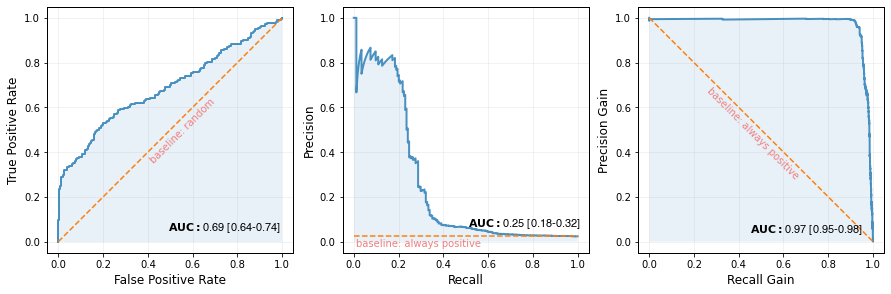

In [38]:

# Calculate ROC-AUC, PR-AUC, PRG-AUC metrics
# Inspired by: https://mateuszbuda.github.io/2019/04/30/stat.html
# --------------------------------------------------
def CalculateScores(y_true, y_proba):
    from Utilities.stat_util import score_ci

    def metric_PR_auc(y_true, y_proba):
        p, r, _ = precision_recall_curve(y_true, y_proba)
        return auc(r, p)
    
    def metric_ROC_auc(y_true, y_proba):
        ROC_Score = roc_auc_score(y_true, y_proba)
        return ROC_Score
    
    def metric_PRG_auc(y_true, y_proba):
        from prg import prg
        # from https://github.com/meeliskull/prg/tree/master/Python_package
        prg_curve = prg.create_prg_curve(y_true, y_proba)
        auprg = prg.calc_auprg(prg_curve)
        return auprg
    
    
    ROC_score, ROC_ci_lower, ROC_ci_upper, ROC_ScoreBootstraps = score_ci(y_true, y_proba, score_fun=metric_ROC_auc)
    PR_score, PR_ci_lower, PR_ci_upper, PR_ScoreBootstraps = score_ci(y_true, y_proba, score_fun=metric_PR_auc)
    PRG_score, PRG_ci_lower, PRG_ci_upper, PRG_ScoreBootstraps = score_ci(y_true, y_proba, score_fun=metric_PRG_auc)
    d_Metrics = {'ROC':[ROC_score, ROC_ci_lower, ROC_ci_upper],
                 'PR':[PR_score, PR_ci_lower, PR_ci_upper],
                 'PRG':[PRG_score, PRG_ci_lower, PRG_ci_upper]}
    
    for metric in list(d_Metrics.keys()):
        d_Metrics[metric] = [ round(x, 2) for x in d_Metrics[metric] ]

    SF_Format = '%0.3f'
    
    print(BoldFont('ROC_AUC:')+SF_Format % d_Metrics['ROC'][0],
          '[ '+SF_Format % d_Metrics['ROC'][1],
          '- '+SF_Format % d_Metrics['ROC'][2], ']')
    
    print(BoldFont('PR_AUC:')+SF_Format % d_Metrics['PR'][0],
          '[ '+SF_Format % d_Metrics['PR'][1],
          '- '+SF_Format % d_Metrics['PR'][2], ']')
    
    print(BoldFont('PRG_AUC:')+SF_Format % d_Metrics['PRG'][0],
          '[ '+SF_Format % d_Metrics['PRG'][1],
          '- '+SF_Format % d_Metrics['PRG'][2], ']')
    
    return d_Metrics
# --------------------------------------------------


# Plot ROC curve
# --------------------------------------------------
def plot_ROC(y_true, y_proba, ax, d_Metrics):
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    ax.plot(fpr, tpr, label='ROC',
            linewidth=2, alpha=0.8)

    # Writing AUC
    String = r"$\bf{AUC: }$" + '%0.2f' % d_Metrics['ROC'][0] + \
                                            ' [' + str(d_Metrics['ROC'][1])[0:4] + \
                                            '-' + str(d_Metrics['ROC'][2])[0:4] + ']'
    ax.text(x=0.49, y=0.05, s=String,
            font='helvetica',
            fontsize=11)
    
    ax.fill_between(fpr, tpr, alpha=0.1, zorder=1)
    
    # plotting Baseline
    Color = np.array([240,128,128])/255
    X = np.linspace(0, 1, 10)
    ax.plot(X, X, linestyle='--', zorder=2)
    ax.text(x=0.4, y=0.35, s='baseline: random', rotation=45,
             size=10,
             color = Color)

    # Axes
    ax.grid('on', alpha=0.2)
    ax.set_xlabel('False Positive Rate', size=12)
    ax.set_ylabel('True Positive Rate', size=12)
    ax.set(adjustable='box', aspect='equal')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
# --------------------------------------------------


# Plot PR curve
# --------------------------------------------------
def plot_PR(y_true, y_proba, ax, d_Metrics):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ax.plot(recall, precision, label='PR',
           linewidth=2, alpha=0.8)

    # plotting Baseline
    Color = np.array([240,128,128])/255
    X = np.linspace(0, 1, 10)
    ax.plot(X, [y_test.mean() for x in X], linestyle='--')
    ax.text(x=0.01, y=-0.02, s='baseline: always positive', rotation=0,
             size=10,
             color = Color)

    # Writing AUC
    String = r"$\bf{AUC: }$" + str( round(d_Metrics['PR'][0], 2)) + \
                                            ' [' + str(d_Metrics['PR'][1])[0:4] + \
                                            '-' + str(d_Metrics['PR'][2])[0:4] + ']'
    ax.text(x=0.51, y=0.07, s=String,
            font='helvetica',
            fontsize=11)
    ax.fill_between(recall, precision, alpha=0.1)

    # Axes
    ax.grid('on', alpha=0.2)
    ax.set_xlabel('Recall', size=12)
    ax.set_ylabel('Precision', size=12)
    ax.set(adjustable='box', aspect='equal')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
# --------------------------------------------------


# Plot PRG curve
# --------------------------------------------------
def plot_PRG(y_true, y_proba, ax, d_Metrics):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    pi = y_test.mean()
    precG = np.array([ (prec-pi)/((1-pi)*prec) for prec in precision ])
    recallG = np.array([ (rec-pi)/((1-pi)*rec) for rec in recall ])
    recallG[precG<0] = 1
    precG[precG<0] = 0
    recallG[recallG<0] = 0
    precG[recallG<0] = 1
    
    ax.plot(recallG, precG, label='PRG',
           linewidth=2, alpha=0.8)

    # plotting Baseline
    Color = np.array([240,128,128])/255
    X = np.linspace(0, 1, 10)
    ax.plot(X, 1-X, linestyle='--')
    ax.text(x=0.25, y=0.28, s='baseline: always positive', rotation=-45,
             size=10,
             color = Color)

    # Writing AUC
    String = r"$\bf{AUC: }$" + str( round(d_Metrics['PRG'][0], 2)) + \
                                            ' [' + str(d_Metrics['PRG'][1])[0:4] + \
                                            '-' + str(d_Metrics['PRG'][2])[0:4] + ']'
    ax.text(x=0.45, y=0.04, s=String,
            font='helvetica',
            fontsize=11)
    ax.fill_between(recallG, precG, alpha=0.1)

    # Axes
    ax.grid('on', alpha=0.2)
    ax.set_xlabel('Recall Gain', size=12)
    ax.set_ylabel('Precision Gain', size=12)
    ax.set(adjustable='box', aspect='equal')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
# --------------------------------------------------


# Calculate ROC score and plot ROC characteristic
# --------------------------------------------------
def PerformanceCurves(clf_RF, X_test, y_test, ListPlots):
    y_proba = clf_RF.predict_proba(X_test)[:, 1]
    y_pred = clf_RF.predict(X_test)
    y_true = y_test.values
    
    # Calculate ROC-AUC and PR-AUC metrics
    d_Metrics = CalculateScores(y_true, y_proba)
    ROC_AUC_Score = d_Metrics['ROC'][0]
    PR_AUC_SCore = d_Metrics['PR'][0]
    PRG_AUC_SCore = d_Metrics['PRG'][0]
    
    # Calculate ROC, PR, PRG curves
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    
    pi = y_test.mean()
    precG = np.array([ (prec-pi)/((1-pi)*prec) for prec in precision ])
    recallG = np.array([ (rec-pi)/((1-pi)*rec) for rec in recall ])
    recallG[precG<0] = 1
    precG[precG<0] = 0
    recallG[recallG<0] = 0
    precG[recallG<0] = 1
    
    fig, ax = plt.subplots(1, len(ListPlots), figsize=(5*len(ListPlots),5))
    if len(ListPlots)==1:
        ax = [ax]
        
    if 'ROC' in ListPlots:
        idx = ListPlots.index('ROC')
        plot_ROC(y_true, y_proba, ax[idx], d_Metrics)
        
    if 'PR' in ListPlots:
        idx = ListPlots.index('PR')
        plot_PR(y_true, y_proba, ax[idx], d_Metrics)        

    if 'PRG' in ListPlots:
        idx = ListPlots.index('PRG')
        plot_PRG(y_true, y_proba, ax[idx], d_Metrics)        
            
    # Fbeta-score
#     beta = 1
#     Fbeta_Score = (1+beta**2)*precision*recall/(beta**2*precision+recall)
#     ax[1].plot(precision, Fbeta_Score) 
# --------------------------------------------------

ListPlots = ['ROC', 'PR', 'PRG']
PerformanceCurves(clf_RF_Optimised, X_test, y_test, ListPlots)

# SaveFigure(plt, 'PerformanceCurves')



## Identify Strong Predictors

In [1447]:

# Exploring Venn-Diagrams on entire data set:
from sklearn.metrics import precision_score, recall_score

L_Tot = list(df_ini.loc[:, 'P_Spell_ID'].values)
# print(len(L_Tot))
N_tot = len(L_Tot)

Filter_Read30 = df_ini.loc[:, 'Read30']==1
L_Read30 = list(df_ini.loc[Filter_Read30, 'P_Spell_ID'].values)
# print(len(L_Read30)/N_tot)

Filter_IndexComplication = df_ini.loc[:, 'Index_complication'] == 1
L_IndexComplication = list(df_ini.loc[Filter_IndexComplication, 'P_Spell_ID'].values)
# print(L_IndexComplication)

Filter_ReadComplication = df_ini.loc[:, 'READ_complication'] == 1
L_ReadComplication = list(df_ini.loc[Filter_ReadComplication, 'P_Spell_ID'].values)
# print(L_ReadComplication)

Filter_Complication = X_ini.loc[:, 'Index_or_read_complication_ReadOrNot'] == 1
Index_Complication = X_ini.loc[Filter_Complication, :].index
L_Complication = list(df_ini.loc[Index_Complication, 'P_Spell_ID'].values)
# print(L_Complication)

y_proba_all = clf_RF_Optimised.predict_proba(X_ini)[:,1]
Threshold_min = 0.7*y_proba_all[Filter_Complication].min()
Filter_Proba = y_proba_all>=Threshold_min
y_pred_all = np.where(Filter_Proba, 1, 0)
print('Complication ratio in predictions: %0.3f' % (100*y_pred_all.mean()), '%')
Filter_Pred = (y_pred_all==1)
Index_Pred = y_ini.loc[Filter_Pred].index
L_Pred = list(df_ini.loc[Index_Pred, 'P_Spell_ID'].values)
# print(L_Pred)

L_Outside = [x for x in L_Tot if x not in (L_Read30+L_IndexComplication+L_ReadComplication)]
# print(len(L_Outside)/N_tot)

Filter_Pred_TP = (y_pred_all==1) & (y_ini==1)
Index_Pred_TP = X_ini.loc[Filter_Pred_TP, :].index
Filter_Pred_FP = (y_pred_all==1) & (y_ini==0)
Index_Pred_FP = X_ini.loc[Filter_Pred_FP, :].index
Filter_Pred_TN = (y_pred_all==0) & (y_ini==0)
Index_Pred_TN = X_ini.loc[Filter_Pred_TN, :].index
Filter_Pred_FN = (y_pred_all==0) & (y_ini==1)
Index_Pred_FN = X_ini.loc[Filter_Pred_FN, :].index

Filter_Pred_P = (y_pred_all==1)
Index_Pred_P = X_ini.loc[Filter_Pred_P, :].index
Filter_Pred_N = (y_pred_all==0)
Index_Pred_N = X_ini.loc[Filter_Pred_N, :].index

# print(list(map(df_FeatureEngineered.loc[Index_Pred_FP, 'READ_TimeDifference'].describe().get, ['25%', '50%', '75%'])))
# print(list(map(df_FeatureEngineered.loc[Index_Pred_TN, 'READ_TimeDifference'].describe().get, ['25%', '50%', '75%'])))
# print(df_FeatureEngineered.loc[Index_Pred_FP, 'READ_TimeDifference'].shape[0])

# Explore Intersections: Read30 and Complications_IndexOrRead
l_Read30_Complications = [x for x in L_Read30 if x in L_Complication]
Prop_30 = 100 * len(l_Read30_Complications) / len(L_Read30)
# print('Percentage of Read30 patients, with a complication code: %0.3f' % Prop_30, '%')

Filter_ReadComplication = df_ini.loc[:, 'READ_complication']==1
L_ReadComplication = list(df_ini.loc[Filter_ReadComplication, 'P_Spell_ID'].values)
l_ReadComplications_Read30 = [x for x in L_ReadComplication if x in L_Read30]
Prop_Read30Complications = 100 * len(l_ReadComplications_Read30) / len(L_ReadComplication)
print('Percentage of patients with a ReadComplication code, that are Read30: %0.3f' % Prop_Read30Complications, '%')



Complication ratio in predictions: 2.333 %
Percentage of patients with a ReadComplication code, that are Read30: 98.507 %


In [1439]:

from scipy import stats

# --------------------------------------------------
def MedianIQR(Series, Unit):
    List = [str(x) for x in list(map(Series.describe().get, ['25%', '50%', '75%', 'mean', 'std']))]
    String = List[0] + ' (' + List[1] + ' - ' + List[2] + ') '+ Unit + ' [' + str(Series.shape[0]) + ']'
    print(String)

def MannWhitneyUTest(V1, V2, alpha):
    U, p = stats.mannwhitneyu(x=V1, y=V2, alternative = 'greater')
    if p<alpha:
        print('Mann-Whitney U-test: significant difference.')
    else:
        print('Mann-Whitney U-test: insufficient information to reject Null hypothesis.')
# --------------------------------------------------

df_FN = df_FeatureEngineered.loc[Index_Pred_FN, :].assign(Location='FN').assign(Prediction='0')
df_TP = df_FeatureEngineered.loc[Index_Pred_TP, :].assign(Location='TP').assign(Prediction='1')
df_FP = df_FeatureEngineered.loc[Index_Pred_FP, :].assign(Location='FP').assign(Prediction='1')
df_TN = df_FeatureEngineered.loc[Index_Pred_TN, :].assign(Location='TN').assign(Prediction='0')

df_TP_FN_FP_TN = pd.concat([df_TP, df_FN, df_FP, df_TN])
df_TP_FN_FP_TN

# Comparison between FalseNegatives and Truepositives: Why are FalseNegatives exluded by the model?
# There should be a significant difference, to explain why FN are predicted as Negatives

print(BoldFont('Comparing FN and TP: Why are FN excluded / TP included by the model?'))
print('Readmission Time, FN:')
MedianIQR(df_FN.loc[:, 'READ_TimeDifference'], 'days')
print('Readmission Time, TP:')
MedianIQR(df_TP.loc[:, 'READ_TimeDifference'], 'days')
print('Rank-sum test:')
V_FN = df_FN.loc[:, 'READ_TimeDifference'].values
V_TP = df_TP.loc[:, 'READ_TimeDifference'].values
MannWhitneyUTest(V_FN, V_TP, alpha)

# Comparison between FalsePositives and All negatives: Why are FalsePositives included by the model?
# There should be a significant difference, to explain why FP are predicted to be different to all negatives
print(BoldFont('Comparing FP and TN: Why are TN excluded / FP included by the model?'))
print('Readmission Time, FP:')
MedianIQR(df_FP.loc[:, 'READ_TimeDifference'], 'days')
print('Readmission Time, TN:')
MedianIQR(df_TN.loc[:, 'READ_TimeDifference'], 'days')
print('Rank-sum test:')
V_FP = df_FP.loc[:, 'READ_TimeDifference'].values
V_TN = df_TN.loc[:, 'READ_TimeDifference'].values
MannWhitneyUTest(V_FP, V_TN, alpha)

print('LOS, FP:')
MedianIQR(df_FeatureEngineered.loc[Index_Pred_FP, 'Spell_Los'], 'days')
print('LOS, TN:')
MedianIQR(df_FeatureEngineered.loc[Index_Pred_TN, 'Spell_Los'], 'days')
print('Rank-sum test:')
V1 = df_FeatureEngineered.loc[Index_Pred_FP, 'Spell_Los'].values
V2 = df_FeatureEngineered.loc[Index_Pred_TN, 'Spell_Los'].values
MannWhitneyUTest(V1, V2, alpha)

print('Age, FP:')
MedianIQR(df_FeatureEngineered.loc[Index_Pred_FP, 'age_of_patient'], 'years old')
print('Age, TN:')
MedianIQR(df_FeatureEngineered.loc[Index_Pred_TN, 'age_of_patient'], 'years old')
print('Rank-sum test:')
V1 = df_FeatureEngineered.loc[Index_Pred_FP, 'age_of_patient'].values
V2 = df_FeatureEngineered.loc[Index_Pred_TN, 'age_of_patient'].values
MannWhitneyUTest(V1, V2, alpha)


 Comparing FN and TP: Why are FN excluded / TP included by the model? 
Readmission Time, FN:
3.0 (7.0 - 15.0) days [795]
Readmission Time, TP:
1.0 (5.0 - 8.0) days [368]
Rank-sum test:
Mann-Whitney U-test: significant difference.
 Comparing FP and TN: Why are TN excluded / FP included by the model? 
Readmission Time, FP:
41.5 (48.0 - 57.25) days [786]
Readmission Time, TN:
44.0 (59.0 - 75.0) days [47516]
Rank-sum test:
Mann-Whitney U-test: significant difference.
LOS, FP:
1.0 (1.0 - 2.0) days [786]
LOS, TN:
0.0 (0.0 - 1.0) days [47516]
Rank-sum test:
Mann-Whitney U-test: significant difference.
Age, FP:
44.0 (59.0 - 73.75) years old [786]
Age, TN:
39.0 (51.0 - 62.0) years old [47516]
Rank-sum test:
Mann-Whitney U-test: significant difference.


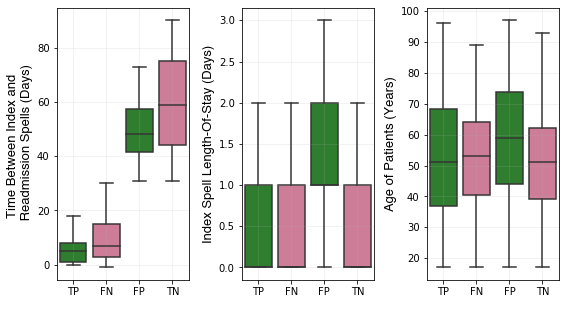

In [1444]:

# --------------------------------------------------
def PlotBoxPlot(df_Plot, FeatureName, axes):
    Opacity = 0.5
    Colour_0 = np.append( np.array([219,112,147])/255, Opacity)
    Colour_1 = np.append( np.array([34,139,34])/255, Opacity)

    Palette = {'1':Colour_1, '0':Colour_0}
    sns.boxplot(data=df_Plot,
                x='Location',
                y=FeatureName,
                ax=axes,
                showfliers=False,
                hue = 'Prediction',
                palette = Palette,
                dodge=False)


    axes.get_legend().remove()

    # plt.legend(loc='lower right',
    #              edgecolor='black',
    #              facecolor='black', framealpha=0.15,
    #              bbox_to_anchor=(1.4, -0.02), ncol=1,
    #              fontsize=12);

# --------------------------------------------------

fig, axes = plt.subplots(1, 3,
                         figsize=(9, 5))
plt.subplots_adjust(wspace = 0.4)

# Plotting Read_TimeDifference
PlotBoxPlot(df_TP_FN_FP_TN, 'READ_TimeDifference', axes[0])

# Plotting Spell LOS
PlotBoxPlot(df_TP_FN_FP_TN, 'Spell_Los', axes[1])

# Plotting age
PlotBoxPlot(df_TP_FN_FP_TN, 'age_of_patient', axes[2])


List_YLabels = ['Time Between Index and \n Readmission Spells (Days)',
                'Index Spell Length-Of-Stay (Days)',
                'Age of Patients (Years)']
for idx, ax in enumerate(axes):
    ax.set_xlabel(' ',
          size = 13,
          fontweight='bold',
          fontname='helvetica');
    ax.set_ylabel(List_YLabels[idx],
          size = 13,
          fontweight='bold',
          fontname='helvetica');
    ax.grid('on', alpha=0.2)

# SaveFigure(plt, 'ModelPredictions_ComparisonGroups')


In [1044]:

# Exploring Venn-Diagrams on test set:
from sklearn.metrics import precision_score, recall_score

Index_Xtest = X_test.index

L_Tot = list(df_ini.loc[Index_Xtest, 'P_Spell_ID'].values)

Filter_Read30 = (y_test == 1)
Index_Read30 = y_test.loc[Filter_Read30].index
Filter_Complication = X_test.loc[:, 'Index_or_read_complication_ReadOrNot'] == 1
Index_Complication = X_test.loc[Filter_Complication, :].index

L_Read30 = list(df_ini.loc[Index_Read30, 'P_Spell_ID'].values)
L_Complications = list(df_ini.loc[Index_Complication, 'P_Spell_ID'].values)

Filter = X_test.loc[:, 'Index_or_read_complication_ReadOrNot'] == 1
Threshold_min = y_proba[Filter].min()
Filter_Proba = y_proba>=Threshold_min
y_pred = np.where(Filter_Proba, 1, 0)

Filter_Predictions = (y_pred==1)
Index_pred = y_test.loc[Filter_Predictions].index
L_Pred = df_ini.loc[Index_pred, 'P_Spell_ID'].values


# Filter = X_test.loc[:, 'Index_or_read_complication_ReadOrNot'] == 1
# Threshold_min = y_proba[Filter].min()
# Filter_Proba = y_proba>=Threshold_min

# y_pred = np.where(Filter_Proba, 1, 0)
# prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# print(precision, recall)

# y_pred.mean()
# y_test.mean()


# pi = y_test.mean()
# precG = (prec-pi)/((1-pi)*prec)
# recallG = (rec-pi)/((1-pi)*rec)
# print(precG, recallG)

# X_test['Index_or_read_complication_ReadOrNot'].mean()


## Visualise strongest predictors

Features with negative contributions:
[]


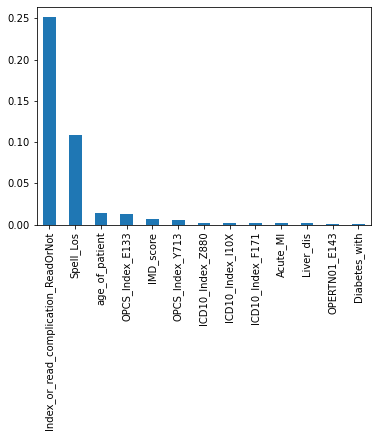

In [836]:

# Visualise strongest predictors using feature permutation importance
# --------------------------------------------------
def FeatureImportance_sklearn(clf, X, y, metric):
    
    def metric_PR_auc(y_true, probas_pred):
        p, r, _ = precision_recall_curve(y_true, probas_pred)
        return auc(r, p)
    metric_PR_auc = make_scorer(metric_PR_auc, needs_proba=True)
    
    metric_ROC_auc = 'roc_auc'
    
    if metric == 'ROC':
        ScoringMetric = metric_ROC_auc
    elif metric == 'PR':
        ScoringMetric = metric_PR_auc
    
    I_Autism = permutation_importance(clf, X, y,
                                      scoring = ScoringMetric,
                                      random_state=1)
    Features = X.columns
    FeatureImportance_Series = pd.Series(I_Autism['importances_mean'], index=Features).sort_values(ascending=False)
    
    FeatureImportance_Series.plot.bar()
    
    print('Features with negative contributions:')
    Filter_Negative = FeatureImportance_Series<=0
    print(list(FeatureImportance_Series[Filter_Negative].index))
    
    return FeatureImportance_Series
# --------------------------------------------------

FeatureImportance_sklearn = FeatureImportance_sklearn(clf_RF_Optimised, X_test, y_test, 'PR')


## Computing Shapley values

Number of tree limit: None
 DONE 


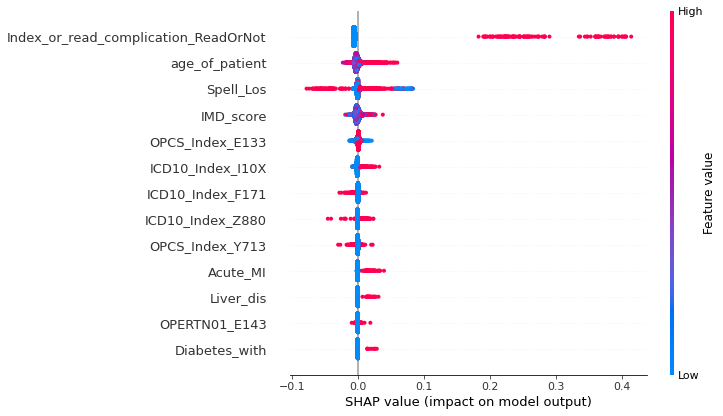

In [1515]:


import shap

def ShapSummaryPlotImportantFeatures(shap_values, X_test, ImportantFeatures_List, FeatureLabels_New):
    Features_Number = range(1, len(X_test.columns)+1)
    df_Features = pd.DataFrame({'Feature':list(X_test.columns), 'Number':Features_Number})
    Filter = df_Features.loc[:, 'Feature'].isin(ImportantFeatures_List)
    ImportantFeatures_Number = list(df_Features.loc[Filter, 'Number'].values)
    ImportantFeatures_Number = [x-1 for x in ImportantFeatures_Number]
    
#     # Rename labels
    FeatureNames = dict(zip(ImportantFeatures_List, FeatureLabels_New))
    X_test = X_test.rename(columns=FeatureNames)

    shap.summary_plot(shap_values[1][:,ImportantFeatures_Number], X_test.iloc[:, ImportantFeatures_Number], show=False)

# Create Tree Explainer object that can calculate shap values
def ComputeShapValues(clf, X_test, Fraction, FeatureList, nTrees_Lim, FeatureLabels_New):
    
    # Sample X_test
#     X_test_Sample = X_test.sample(frac=Fraction, random_state=1)
#     print('Number of predictions:', X_test_Sample.shape[0],
#           'corresponding to %0.2f' % (Fraction*100), '% of entire test set.')
    

    print('Number of tree limit:', nTrees_Lim)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test,
                                        tree_limit=nTrees_Lim, check_additivity=True, approximate=False)
    
    ShapSummaryPlotImportantFeatures(shap_values, X_test, FeatureList, FeatureLabels_New)    
    
    print('\033[1m DONE \033[0m')
    return shap_values

Fraction = 1
FeatureList = FeatureImportance_sklearn.index
nTrees_Lim = None
FeatureLabels_New = FeatureList
shap_values = ComputeShapValues(clf_RF_Optimised, X_test,
                                       Fraction, FeatureList, nTrees_Lim, FeatureLabels_New)



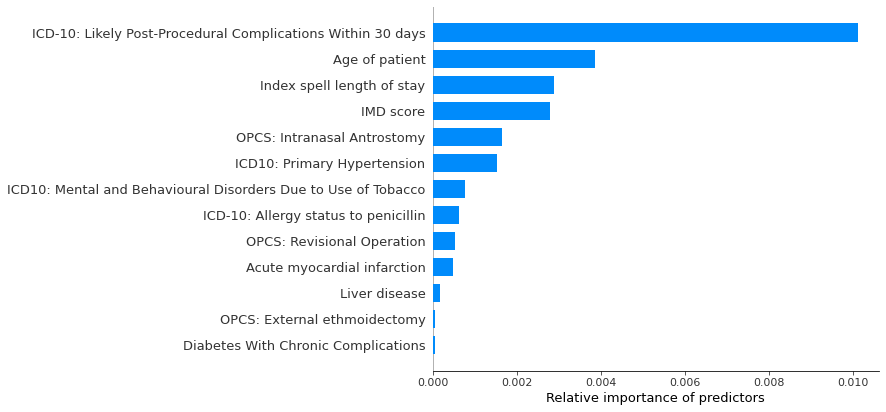

In [1571]:

X_test.columns

dictionary_labels = {'age_of_patient':'Age of patient',
                    'Spell_Los':'Index spell length of stay',
                    'IMD_score':'IMD score',
                    'Acute_MI':'Acute myocardial infarction',
                    'Liver_dis':'Liver disease',
                    'Diabetes_with':'Diabetes With Chronic Complications',
                    'Index_or_read_complication_ReadOrNot':'ICD-10: Likely Post-Procedural Complications Within 30 days',
                    'OPCS_Index_E133':'OPCS: Intranasal Antrostomy',
                    'OPCS_Index_Y713':'OPCS: Revisional Operation',
                    'ICD10_Index_I10X':'ICD10: Primary Hypertension',
                    'ICD10_Index_F171':'ICD10: Mental and Behavioural Disorders Due to Use of Tobacco',
                    'ICD10_Index_Z880':'ICD-10: Allergy status to penicillin',
                    'OPERTN01_E143':'OPCS: External ethmoidectomy'
                    }
X_test_Renamed = X_test.rename(columns=dictionary_labels)
shap.summary_plot(shap_values[1], features=X_test_Renamed, feature_names=X_test_Renamed.columns, plot_type='bar',
                  show=False)

fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('Relative importance of predictors');



 FIGURE SAVED. 


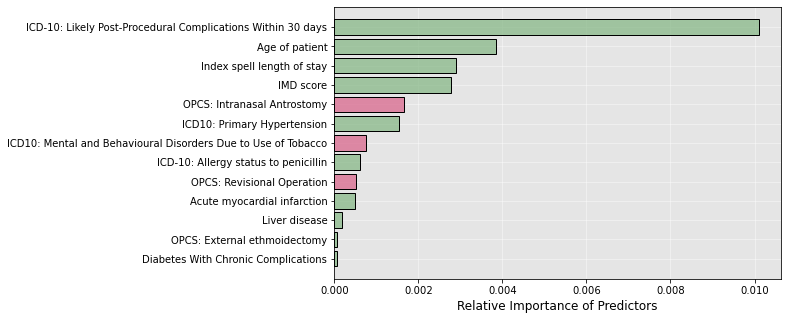

In [1837]:

from scipy.stats import pearsonr, spearmanr, kendalltau

List_Features = list(X_test_Renamed.columns)
List_MeanShap = []
List_SignShap = []

for idx, feature in enumerate(X_test_Renamed):
    List_Shap_Positive = np.array([x for x in (shap_values[1][:, idx]) if x>0])
    List_Shap_Negative = np.array([x for x in (shap_values[1][:, idx]) if x<0])
    List_Shap =  abs(shap_values[1][:, idx])
    Mean = List_Shap.mean()
    List_MeanShap.append(Mean)
    C, p = spearmanr(List_Shap, y_test)
    Score_Qualitative = (List_Shap_Positive.mean() + List_Shap_Negative.mean())/Mean
    List_SignShap.append( Score_Qualitative )
    
    
d_MeanShap = dict(zip(List_Features, List_MeanShap))
df_MeanShap = pd.DataFrame({'Features':d_MeanShap.keys(),
                            'MeanShap':d_MeanShap.values(),
                            'Sign':List_SignShap}).sort_values(by=['MeanShap'], ascending=False)

fig, ax = plt.subplots(figsize=(8,5))
# Plotting bar chart
Opacity = 0.8
Colour_Positive = np.array( [ x/255 for x in [143,188,143] ] + [Opacity] )
Colour_Negative = np.array( [ x/255 for x in [219,112,147] ] + [Opacity] )
Filter_Positive = df_MeanShap['Sign']>0
Features_Positive =  df_MeanShap.loc[Filter_Positive, 'Features'].values
Features_Negative =  df_MeanShap.loc[~Filter_Positive, 'Features'].values
ColorList = [ Colour_Positive if (x in Features_Positive) else Colour_Negative for x in df_MeanShap['Features'] ]

# ax = sns.barplot(x="MeanShap", y="Features", data=df_MeanShap,
#                  hue='Sign', palette=ColorList, dodge=False)
# ax.legend_.remove()

plt.barh(df_MeanShap['Features'][::-1],
         df_MeanShap['MeanShap'][::-1],
         color=ColorList,
         edgecolor='k',
         zorder=2)

plt.grid('on', alpha=0.8, color=[1, 1, 1], linewidth=0.5, zorder=0)
ax.set_facecolor([0, 0, 0, 0.1])
plt.xlabel('Relative Importance of Predictors',
           size=12);

# SaveFigure(plt, 'FeatureImportance_Shap')



Model 2:
Outcome: Compication in either Index or Readmission spell
Features: OPCS, ICD10, Patient characteristics


In [1830]:

# df_MeanShap['Sign']/max(abs(df_MeanShap['Sign']))
df_MeanShap['Sign']


6     27.264389
0      0.853307
1      0.965532
2      0.387742
7     -0.534493
9      1.140202
10    -1.600278
11     3.211018
8     -1.307564
3     19.306834
4     22.830872
12     0.008136
5     34.447697
Name: Sign, dtype: float64

Matthew Correlation Coefficient: 0.30927513690651837


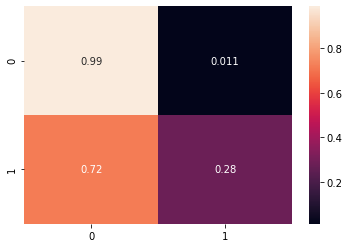

In [849]:

Threshold = 0.1
y_pred = (clf_RF_Optimised.predict_proba(X_test)[:,1]>=Threshold).astype(bool)

CM = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.heatmap(CM, annot=True)
y_pred.sum()

MCC = matthews_corrcoef(y_test, y_pred, sample_weight=None)
print('Matthew Correlation Coefficient:', MCC)


# Testing: Under / Over sampling

In [171]:

from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
x_tl, y_tl = tl.fit_resample(X_trainval, y_trainval)

Counter(y_tl)

clf_RF_Optimised = RandomForestClassifier(n_estimators=263,
                                        min_samples_split=10,
                                        min_samples_leaf=1,
                                        max_depth=70,
                                        max_features='sqrt',
                                        bootstrap=True,
                                        class_weight='balanced_subsample')

clf_RF_Optimised = clf_RF_Optimised.fit(x_tl, y_tl)
# clf_RF_Optimised = clf_RF_Optimised.fit(X_trainval, y_trainval)



 +  ENDOSINUS 
ROC Score: 0.64
Accuracy: 0.98
PR AUC: 0.209


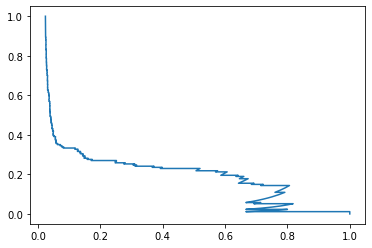

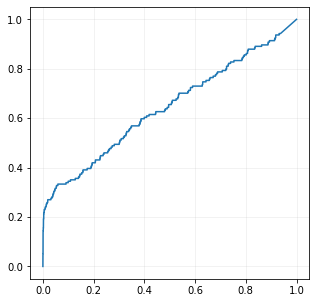

In [172]:

# --------------------------------------------------
def fit_ROC(clf_RF, X_test, y_test, ConditionName):
    y_proba = clf_RF.predict_proba(X_test)[:, 1]
    ROC_Score = roc_auc_score(y_test, y_proba)
    print('\n + \033[1m', ConditionName.upper(), '\033[0m')
    print('ROC Score: %0.2f' % ROC_Score)
    print('Accuracy: %0.2f' % accuracy_score(clf_RF.predict(X_test), y_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(precision, recall)
    auc_score = auc(recall, precision)
    print('PR AUC: %.3f' % auc_score)

    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.grid('on', alpha=0.2)
# --------------------------------------------------

fit_ROC(clf_RF_Optimised, X_test, y_test, 'Endosinus')


# Testing: anomaly detections

<AxesSubplot:>

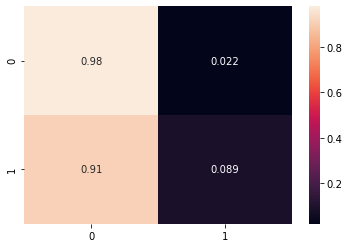

In [122]:

from sklearn.ensemble import IsolationForest

Contamination = y_trainval.mean()


IF = IsolationForest(n_estimators=300, max_samples='auto',
                     contamination=Contamination,
                     max_features=1.0)

IF.fit(X_trainval)
y_pred = IF.predict(X_trainval)

y_pred_2 = [0 if x==1 else 1 for x in y_pred]
y_true = y_trainval

CM = confusion_matrix(y_true, y_pred_2, normalize = 'true')
sns.heatmap(CM, annot=True)


In [125]:

np.linspace(50, 300, 5)


array([ 50. , 112.5, 175. , 237.5, 300. ])

In [37]:

from sklearn.cluster import DBSCAN
import gower

X_trainval_Sub = X_trainval.loc[500:1000, :]
y_trainval_Sub = y_trainval.loc[500:1000]
y_trainval_Sub.sum()

dist_matrix = gower.gower_matrix(X_trainval_Sub)


# Clustering algorithm
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=2, linkage='single', affinity='precomputed')
clusters = model.fit_predict(dist_matrix)
clusters.sum()


# eps_List = np.linspace(0.2, 5, 20)
# TPR_List = []
# for epsVal in eps_List:
#     dbscan = DBSCAN(eps = epsVal, min_samples = 2*X_trainval_Sub.shape[1], metric = "precomputed")
#     pred = dbscan.fit_predict(dist_matrix)
#     anom_index = np.where(pred == -1)
#     y_pred = (-1) * pred
#     y_true = y_trainval_Sub
#     print(y_pred.sum())

#     CM = confusion_matrix(y_true, y_pred)

#     TN = CM[0][0]
#     FN = CM[1][0]
#     TP = CM[1][1]
#     FP = CM[0][1]
#     TPR = TP/(TP+FN)
#     TPR_List.append(TPR)

# plt.scatter(eps_List, TPR_List)


1

In [ ]:

from sklearn.cluster import DBSCAN
import gower

dist_matrix = gower.gower_matrix(X_trainval)


In [ ]:

from sklearn.manifold import MDS 

embedding = MDS(n_components=2, metric= False, n_init=2, max_iter=100, 
                 verbose=0, eps=0.001, n_jobs=2, random_state=101,
                 dissimilarity='precomputed')

X_transformed = embedding.fit_transform(dist_matrix)


# Analysis of Diagnosis of Procedural Codes

In [156]:

df = df_ini.copy()
FeatureName = ['procedure_group', 'READ_procedure',
               'diagnosis_group', 'READ_diagnosis'][3]
Outcome = 'Read30'

if 'READ' in FeatureName:
    Filter_read90 = df.loc[:, 'Read90']==1
    df = df.loc[Filter_read90, :]

df.loc[:, FeatureName+'_List'] = df.loc[:, FeatureName].apply(lambda x: [item for item in str(x).split('~') if item!='-1'])

Filter_Read30 = df.loc[:, 'Read30'] == 1
df_Read30 = df.loc[Filter_Read30, :]
df_NoRead30 = df.loc[~Filter_Read30, :]

def CountCodes(df_ini):
    dictionary_Code = Counter(df_ini.loc[:, FeatureName+'_List'].agg('sum'))
    df_Code_Count = pd.DataFrame.from_dict(dictionary_Code, orient='index').reset_index().rename(columns={'index':'Codes',
                                                                                                           0:'Count'})
    df_Code_Count = df_Code_Count.sort_values(by=['Count'], ascending=False)
    return df_Code_Count

df_Code_Count_Read30 = CountCodes(df_Read30).rename(columns={'Count':'Count_Read30'})
df_Code_Count_NoRead30 = CountCodes(df_NoRead30).rename(columns={'Count':'Count_NoRead30'})
df_Code_Count_Merged = pd.merge(df_Code_Count_Read30, df_Code_Count_NoRead30, on=['Codes'])

                                          

In [157]:

import scipy.stats
df_Code_Count_Merged.loc[:, 'Prop_Read30'] = 100 * df_Code_Count_Merged.loc[:, 'Count_Read30'] / df_Read30.shape[0]
df_Code_Count_Merged.loc[:, 'Prop_NoRead30'] = 100 * df_Code_Count_Merged.loc[:, 'Count_NoRead30'] / df_NoRead30.shape[0]

df_Code_Count_Merged.loc[:, 'rho1 - rho2'] = df_Code_Count_Merged.loc[:, 'Prop_Read30'] - df_Code_Count_Merged.loc[:, 'Prop_NoRead30']
df_Code_Count_Merged.loc[:, 'rho'] = (df_Code_Count_Merged.loc[:, 'Count_Read30']+df_Code_Count_Merged.loc[:, 'Count_NoRead30']) / (df_Read30.shape[0]+df_NoRead30.shape[0])
df_Code_Count_Merged.loc[:, 'StandardError'] = np.sqrt( df_Code_Count_Merged.loc[:, 'rho'] * (1-df_Code_Count_Merged.loc[:, 'rho'] * (1/df_Read30.shape[0] + 1/df_NoRead30.shape[0]) ) )
df_Code_Count_Merged.loc[:, 'TestStatistic'] = df_Code_Count_Merged.loc[:, 'rho1 - rho2'] / df_Code_Count_Merged.loc[:, 'StandardError']
df_Code_Count_Merged.loc[:, 'p_values'] = scipy.stats.norm.sf(abs(df_Code_Count_Merged.loc[:, 'TestStatistic']))

Alpha = 0.05
Filter_pValue5 = df_Code_Count_Merged.loc[:, 'p_values'] <= Alpha
Filter_Read30Counts = df_Code_Count_Merged.loc[:, 'Prop_Read30'] >= 5

ColumnList = ['Codes', 'Count_Read30', 'Count_NoRead30', 'Prop_Read30', 'Prop_NoRead30', 'p_values']
df_Code_Significant = df_Code_Count_Merged.loc[Filter_pValue5 & Filter_Read30Counts, ColumnList]
display(df_Code_Significant)

Code_Significant_List = df_Code_Significant['Codes'].values
Code_Significant_List


,Codes,Count_Read30,Count_NoRead30,Prop_Read30,Prop_NoRead30,p_values
0,R040,288,11,24.763543,1.797386,0.000000e+00
1,I10X,271,134,23.301806,21.895425,1.614317e-03
2,J459,267,180,22.957868,29.411765,3.550142e-38
3,Y838,206,3,17.712812,0.490196,0.000000e+00
4,T810,190,2,16.337059,0.326797,0.000000e+00
5,Z870,167,24,14.359415,3.921569,1.518076e-222
6,Z864,97,74,8.340499,12.091503,6.223167e-34
7,J329,87,32,7.480653,5.228758,1.691667e-18
8,R51X,79,22,6.792777,3.594771,2.731617e-41
9,E119,78,55,6.706793,8.986928,4.022804e-17


array(['R040', 'I10X', 'J459', 'Y838', 'T810', 'Z870', 'Z864', 'J329',
       'R51X', 'E119', 'F171', 'F329'], dtype=object)

In [153]:

# df.loc[:, 'READ_procedure'].apply(lambda x: [item for item in str(x).split('~') if item!='-1'])

# test = '-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1'
# [item for item in test.split('~') if item!='-1']


In [154]:
# df.columns